In [3]:
%load_ext dotenv
%dotenv ../../05_src/.env
%dotenv ../../05_src/.secrets

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [4]:
import sys
sys.path.append('../../05_src/')

In [ ]:

from langgraph.graph import StateGraph, MessagesState, START
from langchain.chat_models import init_chat_model
from langgraph.prebuilt.tool_node import ToolNode, tools_condition
from dotenv import load_dotenv

from utils.logger import get_logger

from course_chat.tools_animals import get_cat_facts, get_dog_facts

_logs = get_logger(__name__)

load_dotenv(".env")
load_dotenv(".secrets")

chat_agent = init_chat_model(
    "openai:gpt-4o-mini"
)

# @traceable(run_type="llm")
def call_model(state: MessagesState):
    """LLM decides whether to call a tool or not"""
    tools = [get_cat_facts, get_dog_facts]
    response = chat_agent.bind_tools(tools).invoke(state["messages"])
    return {
        "messages": [response]
    }

def get_graph():
    tools = [get_cat_facts, get_dog_facts]
    builder = StateGraph(MessagesState)
    builder.add_node(call_model)
    builder.add_node(ToolNode(tools))
    builder.add_edge(START, "call_model")
    builder.add_conditional_edges(
        "call_model",
        tools_condition,
    )
    builder.add_edge("tools", "call_model")
    graph = builder.compile()
    return graph



In [7]:
graph = get_graph()

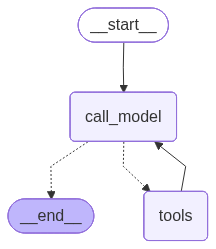

In [8]:


from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


# response = await graph.invoke({"messages": "what is a good album?"})
# response["messages"]

In [10]:
from langchain_core.messages import HumanMessage
response =  graph.invoke({'messages': HumanMessage(content="tell me something about cats?")})
# response["messages"]

In [11]:
response

{'messages': [HumanMessage(content='tell me something about cats?', additional_kwargs={}, response_metadata={}, id='ecd58160-32e5-42c3-84b1-11291344e2e4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_S8r7nMIlno2eeioLGMUzR4JI', 'function': {'arguments': '{}', 'name': 'get_cat_facts'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 96, 'total_tokens': 108, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CZkoVMmrju8Ba9uRMA44sGILVMejM', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--f321e06c-d7dc-4676-af50-91156debcb20-0', tool_calls=[{'name': 'get_cat_facts', 'args': {}, 'id': 'call_S8r7nMIlno2eeioLGMUzR

In [ ]:

# Augment the LLM with tools
tools = [get_cat_facts, get_dog_facts] + mcp_tools
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

In [ ]:
from langchain_core.messages import ToolMessage


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

In [ ]:
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))



In [ ]:
# Invoke
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Tell me 3 things about cats."), 
            HumanMessage(content="Now tell me 2 things about dogs."),
            HumanMessage(content="What is a good indie album?")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()